# Importing Libraries.

In [60]:
#import libraries
import pandas as pd
import numpy as np

#importing liabraries for graphical representation
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix
import matplotlib.patches as mpatches
from matplotlib import rcParams
from matplotlib.cm import rainbow
%matplotlib inline

#Packages for feature engineering
from sklearn.model_selection import train_test_split, StratifiedKFold,cross_val_score
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from statsmodels.tools.eval_measures import rmse
from scipy import stats
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import statsmodels.api as sm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_selection import RFE
from xgboost import XGBClassifier

## Importing the Data set in a dataframe - travel

In [3]:
travel = pd.read_csv('dataset.csv')

In [4]:
travel.head(5)

,ID,Age,Agency,Agency Type,Commision (in value),Destination,Distribution Channel,Duration,Gender,Net Sales,Product Name,Claim
0,45341,28,C2B,Airlines,28.13,SINGAPORE,Online,34,F,112.5,Silver Plan,1
1,12958,37,JZI,Airlines,12.95,PHILIPPINES,Online,53,F,37.0,Basic Plan,0
2,18233,27,EPX,Travel Agency,0.00,UNITED STATES,Online,28,NaN,13.0,Cancellation Plan,0
3,31742,36,EPX,Travel Agency,0.00,SAUDI ARABIA,Online,1,NaN,34.0,Cancellation Plan,0
4,14381,26,CWT,Travel Agency,23.76,THAILAND,Online,33,NaN,39.6,Rental Vehicle Excess Insurance,0


##  Basic Data Hygiene Check.

In [5]:
# Checking the distribution of the claims

(travel.groupby('Claim').size()/travel.shape[0]).round(4)

Claim
0    0.8
1    0.2
dtype: float64

Text(0.5, 1.0, 'Count of each Target Class')

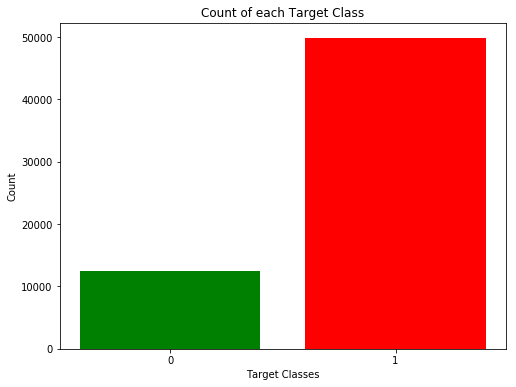

In [56]:
rcParams['figure.figsize'] = 8,6
plt.bar(travel['Claim'].unique(), travel['Claim'].value_counts(), color = ['red', 'green'])
plt.xticks([0, 1])
plt.xlabel('Target Classes')
plt.ylabel('Count')
plt.title('Count of each Target Class')

In [7]:
#checking for the data types and file size.

travel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62288 entries, 0 to 62287
Data columns (total 12 columns):
ID                      62288 non-null int64
Age                     62288 non-null int64
Agency                  62288 non-null object
Agency Type             62288 non-null object
Commision (in value)    62288 non-null float64
Destination             62288 non-null object
Distribution Channel    62288 non-null object
Duration                62288 non-null int64
Gender                  22713 non-null object
Net Sales               62288 non-null float64
Product Name            62288 non-null object
Claim                   62288 non-null int64
dtypes: float64(2), int64(4), object(6)
memory usage: 5.7+ MB


In [8]:
# checking for the null values.

travel.isnull().sum()

ID                          0
Age                         0
Agency                      0
Agency Type                 0
Commision (in value)        0
Destination                 0
Distribution Channel        0
Duration                    0
Gender                  39575
Net Sales                   0
Product Name                0
Claim                       0
dtype: int64

In [9]:
# Checking the weightage of null values.

(travel['Gender'].isnull().sum()/travel.shape[0]*100).round(2)

63.54

#  Inference:
From the above its clear that more then 60% of the data does not have Gender updated. And we also understand that there are no other features that will help us find out whether the individual is male or female.
Thus we will drop this feature

In [54]:
# Check for unique Value in the DataFrame.

travel.nunique()

ID                             50756
Age                               89
Commision (in value)             940
Duration                         429
Net Sales                       1037
Claim                              2
Dest_fe                           71
Agency_fe                         16
Product Name_fe                   25
Agency Type_Travel Agency          2
Distribution Channel_Online        2
dtype: int64

# Analysis:
From the above we can say that Agency Type and Distribution Channel which has just 2 unique values and has dataype object we can use One Hot Encoding and convert them.

We will be left with Destination, Agency and Product Name. We will deep dive into this after some analysis of the rest of the data


In [11]:
# Check for the maximum and minimum values to see if there are any invalid.

travel.describe()

,ID,Age,Commision (in value),Duration,Net Sales,Claim
count,62288.000000,62288.000000,62288.000000,62288.000000,62288.000000,62288.000000
mean,32844.953458,39.666324,12.829703,60.958804,50.717064,0.200006
std,18065.417216,14.014652,23.498745,114.325330,63.166715,0.400008
min,0.000000,0.000000,0.000000,-2.000000,-389.000000,0.000000
25%,17579.000000,33.000000,0.000000,10.000000,20.000000,0.000000
50%,33446.500000,36.000000,1.880000,25.000000,29.700000,0.000000
75%,48532.250000,43.000000,14.440000,59.000000,58.000000,0.000000
max,63323.000000,118.000000,262.760000,4881.000000,682.000000,1.000000


1. Age:
    - minimum: 0 which is possible.
    - maximum: 118, Way too old to travel.
   
Lets check what insurance companies say.
    
Insurance Companies do not give insurance over an age of 85. However there are few who provide insurance upto age of 99.
So giving benefit of doubt to our Safe Travel Insurance travel company we will assume that any individual upto age 99 is valid anything above that needs to be treated.

2. Commission: The data for commission looks valid.


3. Duration:
    - minimum: -2 
    - maximum: 4881
    
so now lets see what insurance companies say.
    - Duration can never be -ve. so this deffinately has to be computed.
    - Duration of 4881. 

Insurance companies do not give insurance over 120 days in India. Lets assume that there is an Annual plan in place then we can say that the maximum tenure of a insurance plan would be 365 days. Also given a fact that one can book a ticket 1 year in advance so we will say that the maximum duration of the insurance cannot be more than
- 731 days(365 + 366 days considering if it is a leap year)

Incase the values are less then 0.05 we will go ahead and drop the data points else we will have to treat them.


4. Net Sales: Minimum has negative values. To check whether sales can be negative or not lets understand how Net Sales is computed.

    Net Sales = The Value for which the insurance is sold - Any expenses incurred/Claim Amount paid

    - So it is possible that the Sales is showing negative if the Claim amount is paid, it can also be negative even if the claim ammount is not paid incases where the insurance was sent for claim and got rejected. Now the expenses incurred for doing investigation of that claim would be more than the actual policy amount paid.

In [12]:
# Calculate % of negative Duration Travels

(travel['Duration'] < 0).sum()/travel.shape[0]*100

0.006421782686873876

In [13]:
(travel['Duration'] > 731).sum()/travel.shape[0]*100

0.020870793732340097

In [14]:
# Now check the weightage of Age
(travel['Age'] > 99).sum()/travel.shape[0]*100

1.4497174415617775

Since the weightage is more than 0.05 we will not be deleting these data, we will instead compute age above 118 as 99 we will not be computing this with median or mean since that would manipluate the data. Thus giving the benefit of doubt to the data we will make it 99

In [15]:
# define a function to make age groups as children, adults and senior

def age_convert(age):
    result = ''
    if(age <= 21):
        result = 'Child'
    elif(age <= 50):
        result = 'Adult'
    else:
        result = 'Senior'
    return result

In [16]:
# Write a function for data preprocessing

def data_pre_processing(df):
    # Add a new column in the Database as Age Group

    df['Age Group'] = df['Age'].map(lambda x: age_convert(x))

    # Dropping Feature Gender
    df.drop('Gender',axis =1, inplace=True)
    
    # Since the minimum duration that any travel can have is 1 day thus we impute it by the column median.
    df['Duration'][df['Duration'] < 0] = df['Duration'].median()

    # As we observed duration of any travel cannot be more than 731 we will impute it as 731.
    df['Duration'][df['Duration'] > 731] = 731
    
    # replacing the values that is greater than 99 with the mean of Senior Age
    df['Age'][df['Age'] > 99] = df[df['Age Group'] == 'Senior']['Age'].mean()
    

In [17]:
data_pre_processing(travel)

C:\Users\athar\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\Users\athar\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [18]:
travel.describe()

,ID,Age,Commision (in value),Duration,Net Sales,Claim
count,62288.000000,62288.000000,62288.000000,62288.000000,62288.000000,62288.000000
mean,32844.953458,38.904537,12.829703,60.182748,50.717064,0.200006
std,18065.417216,10.794050,23.498745,94.270276,63.166715,0.400008
min,0.000000,0.000000,0.000000,0.000000,-389.000000,0.000000
25%,17579.000000,33.000000,0.000000,10.000000,20.000000,0.000000
50%,33446.500000,36.000000,1.880000,25.000000,29.700000,0.000000
75%,48532.250000,43.000000,14.440000,59.000000,58.000000,0.000000
max,63323.000000,88.000000,262.760000,731.000000,682.000000,1.000000


# EXPLORATORY DATA ANALYSIS.

In [19]:
# Creating a dataframe dropping the features with datatype Object

travel_plot = travel.drop(['ID','Agency','Agency Type','Destination','Distribution Channel','Product Name','Claim'], axis = 1)

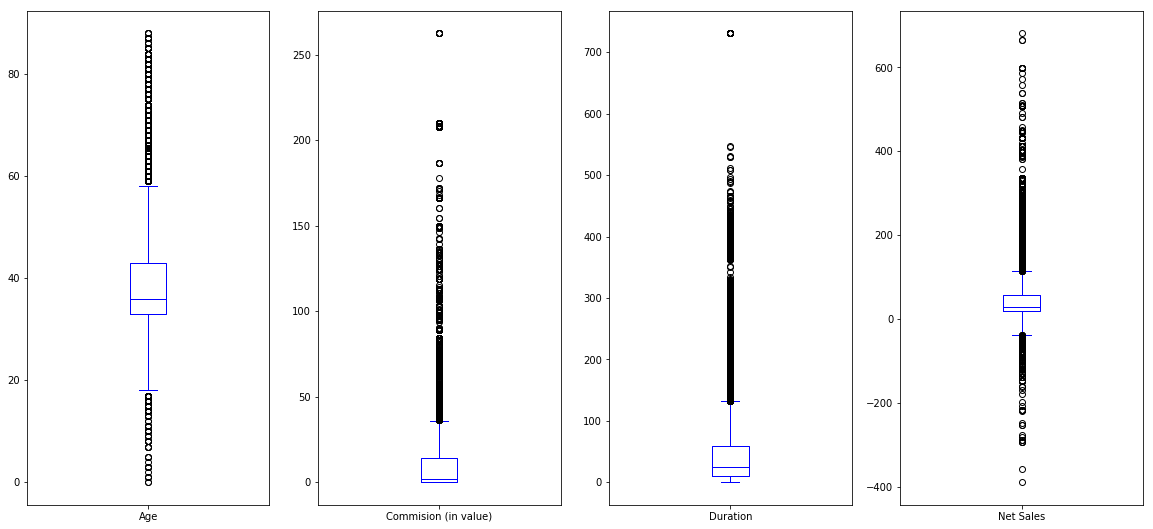

In [20]:
# box and whisker plots

travel_plot.plot(kind='box', subplots=True, layout=(2,4), sharex=False, sharey=False, figsize=(20,20),color='blue')
plt.show()

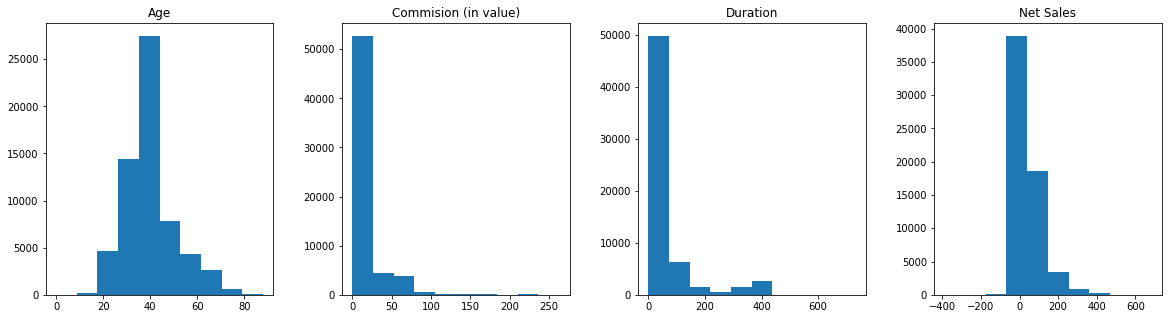

In [21]:
travel_plot.hist(grid=False,sharex=False,sharey=False,figsize=(20,5),layout=(1,4))
plt.show()

We would not be correcting the skewness as the data is valid and whenever in the future if we are getting some 5 to 10 data we wont be able to find skeness there. Thus we will leave it as it is.

# Agencies with maximum claims.

In [22]:
# Finding the Agencies with the Maximum Claims

Claim_mean = (travel.groupby('Agency', as_index=False)['Claim'].mean()).nlargest(10,'Claim')
Claim_mean

,Agency,Claim
2,C2B,0.544827
11,LWC,0.467347
15,TTW,0.376923
10,KML,0.301124
4,CCR,0.222749
5,CSR,0.173333
6,CWT,0.145802
3,CBH,0.141414
13,SSI,0.104813
7,EPX,0.084498


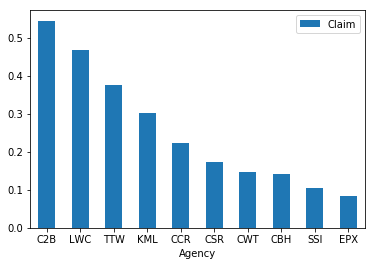

In [61]:
ax = Claim_mean.plot.bar(x='Agency', y='Claim', rot=0)

# Agencies with the most number of net sales.

In [24]:
netsales_mean = (travel.groupby('Agency', as_index=False)['Net Sales'].mean()).nlargest(10,'Net Sales')
netsales_mean

,Agency,Net Sales
11,LWC,126.991327
2,C2B,98.088149
15,TTW,93.300000
0,ADM,56.184615
8,JWT,54.912363
10,KML,52.424719
6,CWT,47.191742
7,EPX,33.668716
9,JZI,32.747784
5,CSR,31.706667


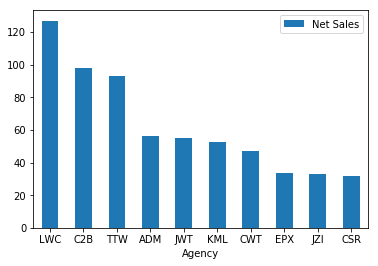

In [62]:
ax1 = netsales_mean.plot.bar(x='Agency', y='Net Sales', rot=0)

Agency      
Claim              0     1
Agency Type               
Airlines       13481  7991
Travel Agency  36349  4467

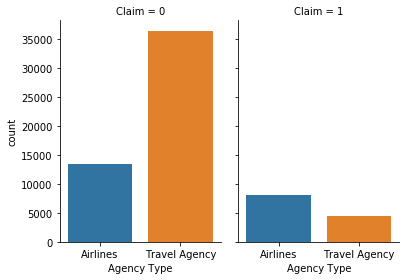

In [26]:
plot2 = sns.catplot(x="Agency Type", col="Claim",data=travel, kind="count",height=4, aspect=.7)
travel.pivot_table(index=['Agency Type'],columns=['Claim'], values=['Agency'], aggfunc='count')

In [27]:
travel.pivot_table(index = ['Product Name'], values = ['Net Sales'], aggfunc = 'mean')

,Net Sales
Product Name,
1 way Comprehensive Plan,27.901674
2 way Comprehensive Plan,44.147544
24 Protect,20.976425
Annual Gold Plan,343.186493
Annual Silver Plan,229.306389
Annual Travel Protect Gold,251.299495
Annual Travel Protect Platinum,328.202632
Annual Travel Protect Silver,206.034766
Basic Plan,26.449732


In [28]:
travel.pivot_table(index = ['Age Group'], values = ['Net Sales'], aggfunc = 'count')

,Net Sales
Age Group,
Adult,52582
Child,828
Senior,8878


In [29]:
travel.groupby('Age Group')['Claim'].value_counts()

Age Group  Claim
Adult      0        42203
           1        10379
Child      0          605
           1          223
Senior     0         7022
           1         1856
Name: Claim, dtype: int64

<Figure size 288x288 with 0 Axes>

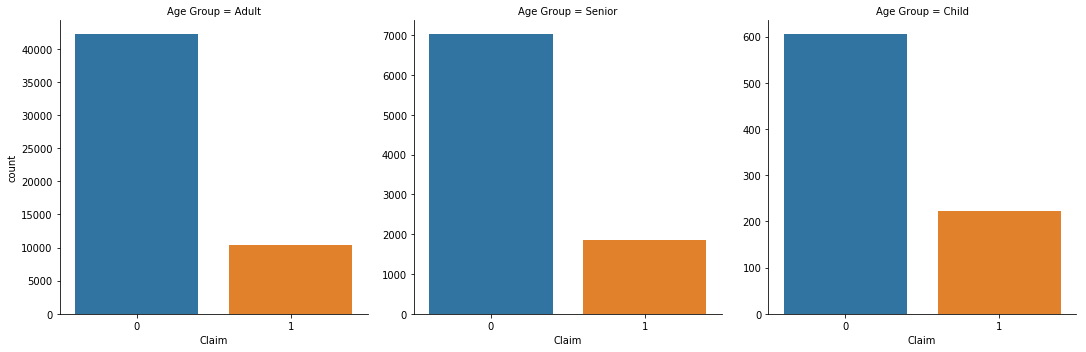

In [30]:
fig = plt.figure(figsize = (4,4))
sns.catplot('Claim', col = 'Age Group', data = travel, col_wrap =3, kind='count',sharey=False)

In [31]:
# Converting all IDs to sensible numbers (Risk of default - inspired by WOE)
travel['Destination_risk'] = travel.groupby('Destination')['Claim'].transform('mean')

In [32]:
def Coutry_Categories(value):
    result = ''
    if(value >= 0.3):
        result = '(1) High Risk - More than 30% Claimed'
    elif(value >= 0.2):
        result = '(2) Medium Risk - More than 20% Claimed'
    elif(value > 0):
        result = '(3) Low Risk - More than 1% Claimed'
    else:
        result = '(4) No Risk Countries'
    return result

In [33]:
travel['Risk of Countries'] = travel['Destination_risk'].map(lambda x: Coutry_Categories(x))

In [34]:
travel.head(5)

,ID,Age,Agency,Agency Type,Commision (in value),Destination,Distribution Channel,Duration,Net Sales,Product Name,Claim,Age Group,Destination_risk,Risk of Countries
0,45341,28.0,C2B,Airlines,28.13,SINGAPORE,Online,34,112.5,Silver Plan,1,Adult,0.427905,(1) High Risk - More than 30% Claimed
1,12958,37.0,JZI,Airlines,12.95,PHILIPPINES,Online,53,37.0,Basic Plan,0,Adult,0.052657,(3) Low Risk - More than 1% Claimed
2,18233,27.0,EPX,Travel Agency,0.00,UNITED STATES,Online,28,13.0,Cancellation Plan,0,Adult,0.206539,(2) Medium Risk - More than 20% Claimed
3,31742,36.0,EPX,Travel Agency,0.00,SAUDI ARABIA,Online,1,34.0,Cancellation Plan,0,Adult,0.000000,(4) No Risk Countries
4,14381,26.0,CWT,Travel Agency,23.76,THAILAND,Online,33,39.6,Rental Vehicle Excess Insurance,0,Adult,0.091330,(3) Low Risk - More than 1% Claimed


# Feature Engineering

In [35]:
travel.head(1)

,ID,Age,Agency,Agency Type,Commision (in value),Destination,Distribution Channel,Duration,Net Sales,Product Name,Claim,Age Group,Destination_risk,Risk of Countries
0,45341,28.0,C2B,Airlines,28.13,SINGAPORE,Online,34,112.5,Silver Plan,1,Adult,0.427905,(1) High Risk - More than 30% Claimed


In [36]:
def feature_processing(df):
    # Converting all categorical columns into numeric using frequency encoding, label encoding and one-hot encoding.
    fe = df.groupby('Destination').size()/len(df)
    df.loc[:,'Dest_fe'] = df['Destination'].map(fe)
    fe_1 = df.groupby('Agency').size()/len(df)
    df.loc[:,'Agency_fe'] = df['Agency'].map(fe_1)
    fe_2 = df.groupby('Product Name').size()/len(df)    
    df.loc[:,'Product Name_fe'] = df['Product Name'].map(fe_2)
    df.drop(columns='Agency',axis=1,inplace=True)
    df.drop(columns='Destination',axis=1,inplace=True)
    df.drop(columns='Product Name',axis=1,inplace=True)
    df.drop(columns='Age Group',axis=1,inplace=True)
    df = pd.get_dummies(df, columns=['Agency Type','Distribution Channel'], drop_first=True)

In [37]:
feature_processing(travel)

In [38]:
travel.head(5)

,ID,Age,Agency Type,Commision (in value),Distribution Channel,Duration,Net Sales,Claim,Destination_risk,Risk of Countries,Dest_fe,Agency_fe,Product Name_fe
0,45341,28.0,Airlines,28.13,Online,34,112.5,1,0.427905,(1) High Risk - More than 30% Claimed,0.285705,0.218469,0.058535
1,12958,37.0,Airlines,12.95,Online,53,37.0,0,0.052657,(3) Low Risk - More than 1% Claimed,0.032928,0.086951,0.074894
2,18233,27.0,Travel Agency,0.00,Online,28,13.0,0,0.206539,(2) Medium Risk - More than 20% Claimed,0.040265,0.488296,0.246500
3,31742,36.0,Travel Agency,0.00,Online,1,34.0,0,0.000000,(4) No Risk Countries,0.000819,0.488296,0.246500
4,14381,26.0,Travel Agency,23.76,Online,33,39.6,0,0.091330,(3) Low Risk - More than 1% Claimed,0.083146,0.127729,0.127729


In [40]:
travel.drop(columns=['Risk of Countries'],axis=1,inplace=True)

In [41]:
travel.drop(columns=['Destination_risk'],axis=1,inplace=True)

In [42]:
travel = pd.get_dummies(travel, columns=['Agency Type','Distribution Channel'], drop_first=True)

In [43]:
travel.head(5)

,ID,Age,Commision (in value),Duration,Net Sales,Claim,Dest_fe,Agency_fe,Product Name_fe,Agency Type_Travel Agency,Distribution Channel_Online
0,45341,28.0,28.13,34,112.5,1,0.285705,0.218469,0.058535,0,1
1,12958,37.0,12.95,53,37.0,0,0.032928,0.086951,0.074894,0,1
2,18233,27.0,0.00,28,13.0,0,0.040265,0.488296,0.246500,1,1
3,31742,36.0,0.00,1,34.0,0,0.000819,0.488296,0.246500,1,1
4,14381,26.0,23.76,33,39.6,0,0.083146,0.127729,0.127729,1,1


# Preparing and training a baseline model.

In [44]:
X = travel.drop('Claim', axis = 1)
Y = travel['Claim']

In [46]:
# Multi colinearity detection
def plot_heatmap(df, fig_size=(10, 7)):
    fig = plt.figure(figsize=fig_size)
    sns.heatmap(df.corr(), annot=True)
    plt.title('Heatmap for detecting multicollinearity', fontsize=16, color='navy')
    plt.show()

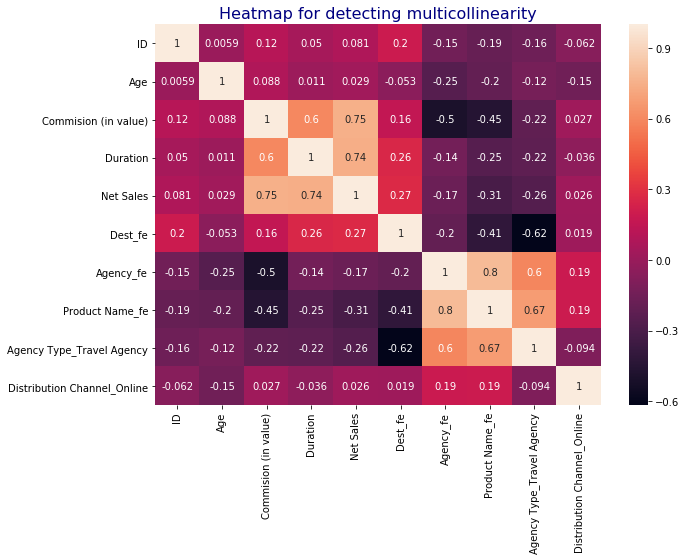

In [47]:
plot_heatmap(X)

# Inference-
    
   From the above heat-map we can see that there is not a high co-relation between any features and hence we can continue with all of the above features to train our model.

# Train-Test Split

In [48]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, train_size = 0.7, random_state = 7)

# Random Forest Classifier.

In [49]:
rf = RandomForestClassifier()
rf.fit(X_train, Y_train)
y_pred_rf = rf.predict(X_test)
print(accuracy_score(Y_test, y_pred_rf))
print(classification_report(Y_test, y_pred_rf))

C:\Users\athar\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.9935249103654947
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     14972
           1       0.97      1.00      0.98      3715

    accuracy                           0.99     18687
   macro avg       0.98      1.00      0.99     18687
weighted avg       0.99      0.99      0.99     18687



# Logistic Regression

In [50]:
logr = LogisticRegression()
logr.fit(X_train,Y_train)
y_pred = logr.predict(X_test)
print(accuracy_score(Y_test, y_pred))
print(classification_report(Y_test, y_pred))

C:\Users\athar\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.8175737143468722
              precision    recall  f1-score   support

           0       0.83      0.97      0.90     14972
           1       0.64      0.19      0.29      3715

    accuracy                           0.82     18687
   macro avg       0.73      0.58      0.59     18687
weighted avg       0.79      0.82      0.78     18687



# Conclusion -

  In the above project we used Machine Learning to predict whether a person would claim his/her travel insurance and built a baseline model using Random Forest Classifier and Logistic Regression. A fair amount of exploratory data analysis has also beend done on the dataset which helped us gain various insights on the given data and helped us in feature engineering . More emphasis on feature selection can be done further down the road but I stopped at the baseline as the results for precision and recall were pretty good. 